# Predicting Agua Potabilization

Data source: water_potability.csv

Predicting: 0 no potable, 1 potable

(Bad Model)

## 1. Prepare environment

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from environment import prepare_environment

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from torch.utils.data import TensorDataset, DataLoader, random_split
from torchvision.transforms import v2
from torchmetrics import Accuracy

In [2]:
# Global variables
SEED = 42

In [3]:
# Check if your GPU driver and CUDA is enabled and accessible by PyTorch
torch.cuda.is_available()

True

In [4]:
# Environment configuration
torch.set_printoptions(precision=10)
np.random.seed(SEED)

prepare_environment()

## 2. Read dataset

In [5]:
df = pd.read_csv('data-sources/water_potability.csv')
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,0.587349,0.577747,0.386298,0.568199,0.647347,0.292985,0.654522,0.795029,0.630115,0
1,0.643654,0.441300,0.314381,0.439304,0.514545,0.356685,0.377248,0.202914,0.520358,0
2,0.388934,0.470876,0.506122,0.524364,0.561537,0.142913,0.249922,0.401487,0.219973,0
3,0.725820,0.715942,0.506141,0.521683,0.751819,0.148683,0.467200,0.658678,0.242428,0
4,0.610517,0.532588,0.237701,0.270288,0.495155,0.494792,0.409721,0.469762,0.585049,0


## 3. Split into train, valid and test

In [6]:
# Setting X and y
features = df.drop(columns='Potability').values
labels = df['Potability'].values

# Encoding the target variable
labels = F.one_hot(torch.tensor(labels), num_classes=len(set(labels)))

# Instantiate dataset class
dataset = TensorDataset(torch.tensor(features).float(), labels.float())

# Splitting into training, validation and testing set
set_train, set_val = random_split(dataset, [.8, .2])
set_val, set_test = random_split(set_val, [.5, .5])

len(set_train), len(set_val), len(set_test)

(1609, 201, 201)

In [7]:
# Creating dataloaders
loader_train = DataLoader(set_train, batch_size=2000, shuffle=True)
loader_val = DataLoader(set_val, batch_size=2000, shuffle=True)
loader_test = DataLoader(set_test, batch_size=2000, shuffle=True)

len(loader_train), len(loader_val), len(loader_test)  # Just one batch created

(1, 1, 1)

## 4. Build the model

In [8]:
# Create multi classification model
model = nn.Sequential(
    nn.Linear(9, 16),
    nn.Linear(16, 4),
    nn.Linear(4, 2),
    nn.Sigmoid()  # Softmax activation
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Create accuracy metric
accuracy = Accuracy(task="multiclass", num_classes=2)

## 5. Train on the training set

In [9]:
# Set the model to training mode
model.train()

# Loop through the dataset multiple times
losses = []
epochs = int(1e3)
for epoch in range(epochs):
    for data in loader_train:
        X, y = data                                # Get feature and target from the data loader
        optimizer.zero_grad()                      # zero the parameter gradients
        y_pred = model(X)                          # Run a forward pass
        loss = criterion(y_pred, y)                # Compute loss 
        loss.backward()                            # Backward pass
        optimizer.step()                           # Optimization
        acc = accuracy(y_pred, y.argmax(dim=-1))   # Calculate accuracy
    
    losses.append(loss.item())         # Record the loss per epoch
    if (epoch + 1) % 100 == 0:         # Print the loss every 100 epochs
        print(f'Epoch [{epoch+1}], Loss: {loss.item():.4f}')

training_loss = loss
training_acc = accuracy.compute()
print(f"Training Accuracy: {training_acc}")

# Reset the metric for next evaluation 
accuracy.reset()

Epoch [100], Loss: 0.6806
Epoch [200], Loss: 0.6785
Epoch [300], Loss: 0.6768
Epoch [400], Loss: 0.6757
Epoch [500], Loss: 0.6752
Epoch [600], Loss: 0.6750
Epoch [700], Loss: 0.6749
Epoch [800], Loss: 0.6749
Epoch [900], Loss: 0.6749
Epoch [1000], Loss: 0.6748
Training Accuracy: 0.596022367477417


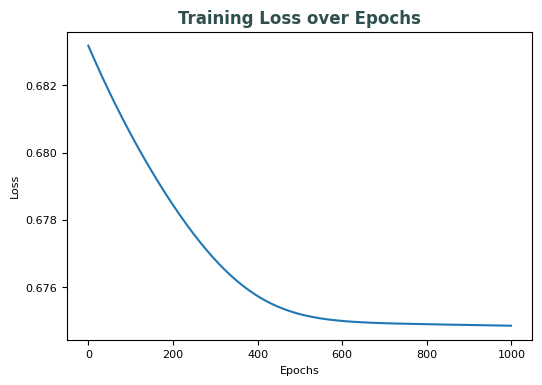

In [10]:
# Visualizing the loss data in training set
fig = plt.figure(figsize=(6,4))
plt.plot(range(epochs), losses)
plt.title("Training Loss over Epochs")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## 6. Evaluate model

In [11]:
# Set the model to evaluation mode
model.eval()

# Iterating over validation dataloader
with torch.no_grad():
    for data in loader_val:
        X, y = data                                # Get feature and target from the data loader
        y_pred = model(X)                          # Get predictions
        loss = criterion(y_pred, y)                # Calculate the loss

# Calculate the mean loss value
print(f'Training   Set: Loss >> {training_loss}')
print(f'Validation Set: Loss >> {loss}')

Training   Set: Loss >> 0.6748490929603577
Validation Set: Loss >> 0.6631059646606445


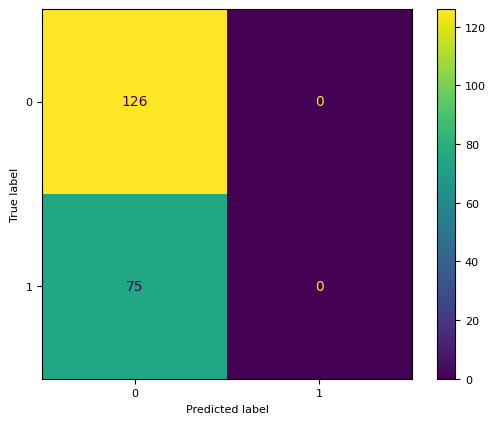

In [12]:
cm = confusion_matrix(y.argmax(dim=-1).numpy().flatten(), 
                      y_pred.argmax(dim=-1).numpy().flatten())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [13]:
pd.DataFrame({
    'y_true': y.argmax(dim=-1).numpy().flatten(),
    'y_pred': y_pred.argmax(dim=-1).numpy().flatten(),
    'Accerted': ['True' 
                 if y[i].argmax(dim=-1).numpy().flatten() == y_pred[i].argmax(dim=-1).numpy().flatten()
                 else ''
                 for i in range(len(y))] 
})

,y_true,y_pred,Accerted
0,0,0,True
1,1,0,
2,0,0,True
3,0,0,True
4,1,0,
...,...,...,...
196,0,0,True
197,0,0,True
198,0,0,True
199,0,0,True


----------------------------------